In [13]:
import scanpy as sc
adata=sc.read_h5ad("./data/GSE280883_cell_anova.h5ad")
print(adata)

AnnData object with n_obs × n_vars = 91752 × 22831
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'seq_folder', 'nUMI', 'nGene', 'log10GenesPerUMI', 'mitoRatio', 'cells', 'sample', 'replicate', 'compartment', 'source', 'day', 'batch', 'multiplet_state', 'ident'
    var: 'gene_id'
    uns: 'X_name'
    layers: 'logcounts'


In [14]:
import numpy as np
for i in adata.obs.columns:
    try:
        unique=np.unique(adata.obs[i])
        if len(unique)<100:
            print(i, unique)
    except:
        continue
print(adata.X[:10,:10])

orig.ident ['D10' 'D2' 'D20' 'D3.5']
seq_folder ['SeuratProject']
sample ['C' 'SR']
replicate [1. 2. 3. 4.]
compartment ['EPI' 'LP']
source ['CY' 'LL']
day [ 2.   3.5 10.  20. ]
batch ['10CCYEPI1' '10CCYLP1' '10SRCYEPI1' '10SRCYLP1' '10SRLLEPI1' '20CCYEPI1'
 '20CCYLP1' '20SRCYEPI1' '20SRCYLP1' '2CCYEPI1' '2CCYLP1' '2SRCYEPI1'
 '2SRCYLP1' '2SRCYLP2' '3.5CLLEPI1' '3.5CLLEPI2' '3.5SRLLEPI1'
 '3.5SRLLEPI2' '3.5SRLLEPI3' '3.5SRLLEPI4']
multiplet_state ['singlet']
ident ['D10' 'D2' 'D20' 'D3.5']
  (0, 5)	3.0
  (1, 5)	4.0
  (2, 5)	1.0
  (5, 5)	3.0
  (8, 5)	4.0
  (0, 6)	5.0
  (1, 6)	1.0
  (4, 6)	1.0
  (5, 6)	2.0
  (8, 6)	5.0
  (9, 6)	1.0
  (0, 7)	2.0
  (1, 7)	4.0
  (2, 7)	1.0
  (4, 7)	1.0
  (5, 7)	1.0
  (8, 7)	3.0
  (2, 9)	2.0
  (5, 9)	1.0


In [15]:
batch_real=[]
for i in range(adata.shape[0]):
    batch_real.append(str(adata.obs['orig.ident'][i])+"__"+str(adata.obs['source'][i])+"__"+str(adata.obs['replicate'][i]))
uniques=np.unique(np.array(batch_real))
print(uniques)

adata.obs["real_batch"]=np.array(batch_real)

adata.obs["replicate"]=np.array([str(i) for i in adata.obs["replicate"]])

adata.write_h5ad("./data/mouse.h5ad")

/tmp/ipykernel_751396/2319539134.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  batch_real.append(str(adata.obs['orig.ident'][i])+"__"+str(adata.obs['source'][i])+"__"+str(adata.obs['replicate'][i]))


['D10__CY__1.0' 'D10__LL__1.0' 'D20__CY__1.0' 'D2__CY__1.0' 'D2__CY__2.0'
 'D3.5__LL__1.0' 'D3.5__LL__2.0' 'D3.5__LL__3.0' 'D3.5__LL__4.0']


In [6]:
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=10)

sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


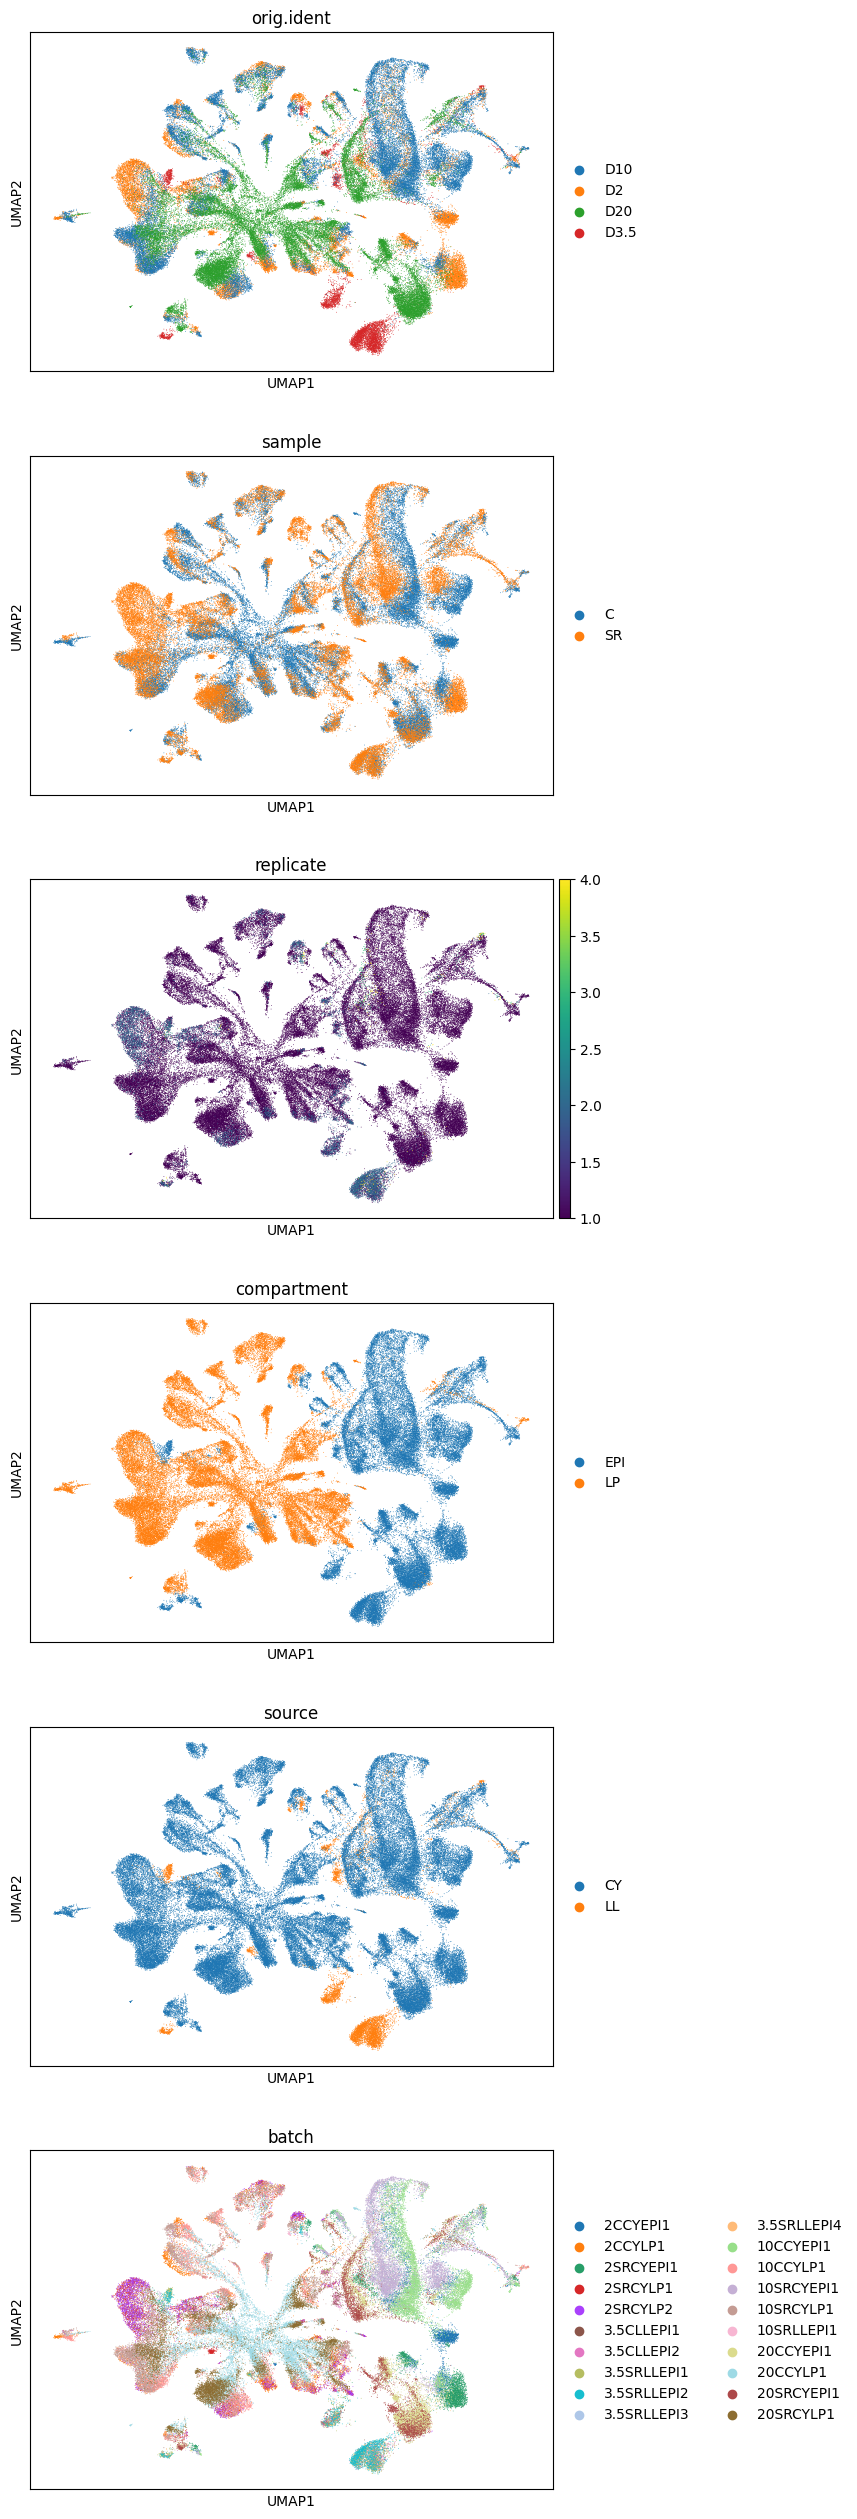

In [7]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var["highly_variable"]]
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata,color=["orig.ident","sample","replicate","compartment","source","batch"],ncols=1)

In [ ]:
from ndreamer import NDreamer

model = NDreamer(adata, condition_key="sample", contorl_name='C', num_hvg=2000, require_batch=True,
                            batch_key=['orig.ident',"replicate","source"],
                            resolution_low=0.5, resolution_high=7, cluster_method="Leiden", embedding_dim=512,
                            codebooks=[1024 for i in range(32)],
                            codebook_dim=8, encoder_hidden=[1024, 512], decoder_hidden=[512, 1024], z_dim=256,
                            cos_loss_scaler=20, random_seed=123, batch_size=1024, epoches=10, lr=1e-3,
                            triplet_margin=5,independent_loss_scaler=1000, save_pth="./mouse/",
                            developer_test_mode=False,
                            library_size_normalize_adata=False,
                            save_preprocessed_adata_path="./mouse/preprocessed.h5ad",
                            KL_scaler=5e-3, reconstruct_scaler=1, triplet_scaler=5, num_triplets_per_label=15,
                            tau=0.01, commitment_loss_scaler=1, cluster_correlation_scaler=50,reset_threshold=1/1024,
                            reset_interval=30,try_identify_cb_specific_subtypes=False,
                            local_neighborhood_loss_scaler=1,local_neighbor_sigma=1,
                            try_identify_perturb_escaped_cell=False,n_neighbors=20,
                            local_neighbor_across_cluster_scaler=20)

model.train_model()
model.get_modifier_space()

model.decompose_true_expression_batch_effect_all(nearest_neighbor=1,bandwidth=1)
model.Estmiate_ITE_all(nearest_neighbor=1,bandwidth=1)

In [ ]:
from ndreamer import NDreamer

model = NDreamer(adata, condition_key="sample", contorl_name='C', num_hvg=2000, require_batch=True,
                            batch_key='real_batch',
                            resolution_low=0.5, resolution_high=7, cluster_method="Leiden", embedding_dim=512,
                            codebooks=[1024 for i in range(32)],
                            codebook_dim=8, encoder_hidden=[1024, 512], decoder_hidden=[512, 1024], z_dim=256,
                            cos_loss_scaler=20, random_seed=123, batch_size=1024, epoches=10, lr=1e-3,
                            triplet_margin=5,independent_loss_scaler=1000, save_pth="./mouse_batch/",
                            developer_test_mode=False,
                            library_size_normalize_adata=False,
                            save_preprocessed_adata_path="./mouse_batch/preprocessed.h5ad",
                            KL_scaler=5e-3, reconstruct_scaler=1, triplet_scaler=5, num_triplets_per_label=15,
                            tau=0.01, commitment_loss_scaler=1, cluster_correlation_scaler=50,reset_threshold=1/1024,
                            reset_interval=30,try_identify_cb_specific_subtypes=False,
                            local_neighborhood_loss_scaler=1,local_neighbor_sigma=1,
                            try_identify_perturb_escaped_cell=False,n_neighbors=20,
                            local_neighbor_across_cluster_scaler=20)

model.train_model()
model.get_modifier_space()

model.decompose_true_expression_batch_effect_all(nearest_neighbor=1,bandwidth=1)
model.Estmiate_ITE_all(nearest_neighbor=1,bandwidth=1)